In [45]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Define Plotting Functions

In [46]:
def plot_loss(history):
    fig = plt.figure()
    plt.plot(history['loss'], color='teal', label='Training Loss')
    plt.plot(history['val_loss'], color='orange', label='Validation Loss')
    plt.legend(loc="upper right", fontsize=15)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    fig.set_size_inches(12, 6)
    plt.show()

In [47]:
def plot_accuracy(lower_lim, upper_lim, history):
    fig = plt.figure()
    plt.plot(history['accuracy'], color='teal', label='Training Accuracy')
    plt.plot(history['val_accuracy'], color='orange', label='Validation Accuracy')
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    fig.set_size_inches(12, 6)
    plt.ylim(lower_lim, upper_lim)
    plt.show()

In [48]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
    plt.figure(figsize=(15, 12))
    heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class', fontsize=20)
    plt.ylabel('True Class', fontsize=20)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    heatmap.tick_params(axis='x', which='major', pad=10)
    heatmap.tick_params(axis='y', which='major', pad=10)
    
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label('Number of Samples', fontsize=15, rotation=90, labelpad=10)
    cbar.ax.yaxis.set_label_position('left')
    plt.show()
    return conf_matrix

In [49]:
def plot_normalised_confusion_matrix(conf_matrix):
    class_totals = np.sum(conf_matrix, axis=1)

    normalised_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
    for i in range(len(class_totals)):
        if class_totals[i] != 0:
            normalised_conf_matrix[i, :] = conf_matrix[i, :] / class_totals[i] * 100

    plt.figure(figsize=(15, 12))
    heatmap = sns.heatmap(normalised_conf_matrix, annot=True, fmt='.1f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Class', fontsize=20)
    plt.ylabel('True Class', fontsize=20)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label('% of Samples', fontsize=15, rotation=90, labelpad=10)
    cbar.ax.yaxis.set_label_position('left')
    plt.show()
    return normalised_conf_matrix

# 1. Baseline Model Metrics

In [50]:
folder = 'pickle'
inner_folder = 'model'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)
    
with open(os.path.join(folder, inner_folder, 'history_pickle'), 'rb') as f:
    loaded_history = pickle.load(f)

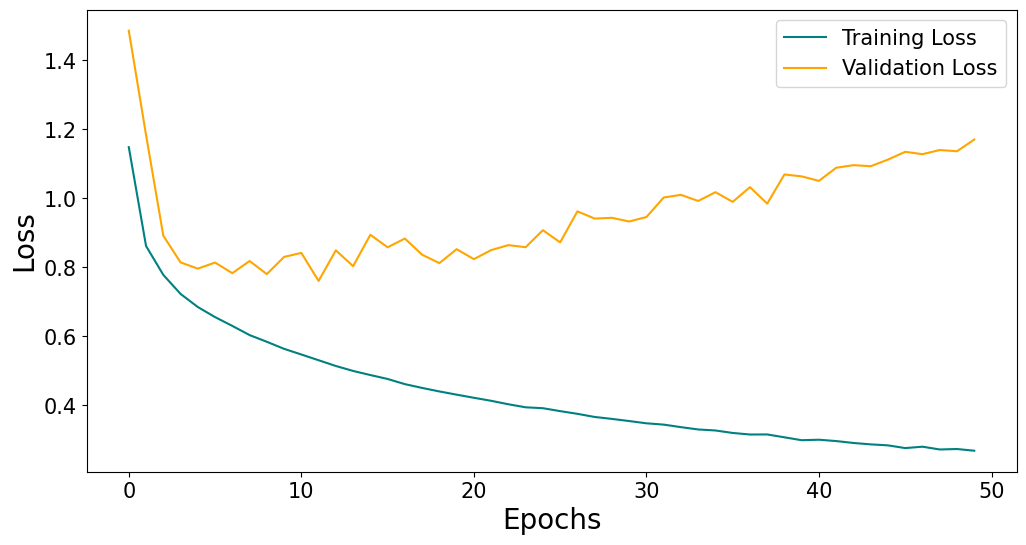

In [51]:
plot_loss(loaded_history)

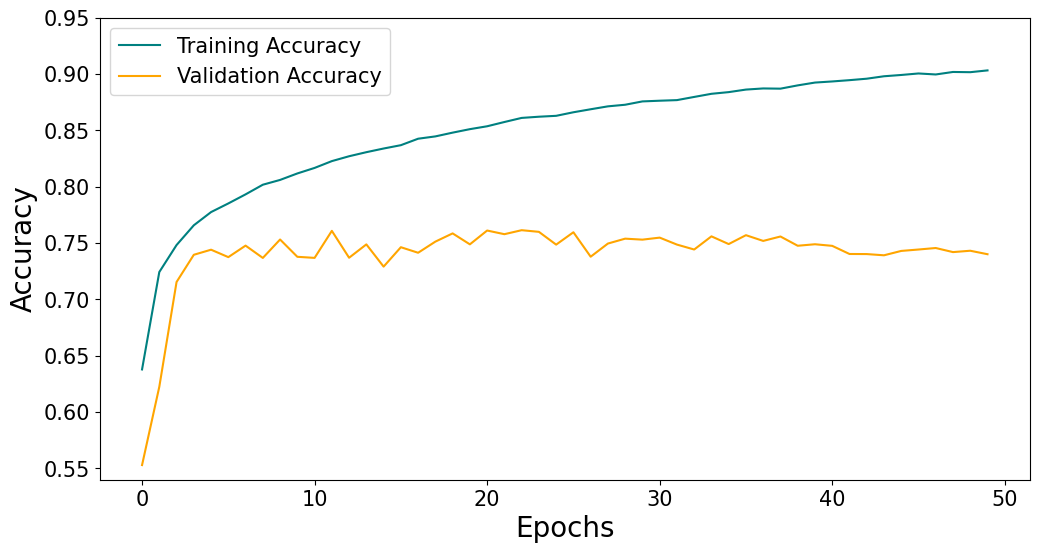

In [52]:
plot_accuracy(0.54, 0.95, loaded_history)

In [53]:
def reset_metrics():
    global acc
    acc = CategoricalAccuracy()

    accuracy_per_class = [CategoricalAccuracy() for _ in range(21)]

In [54]:
val_data = tf.keras.utils.image_dataset_from_directory('Validation', image_size=(250, 250))
val_data = val_data.map(lambda image,label: (image/255, label))

Found 23973 files belonging to 21 classes.


In [55]:
def predict(model):
    global y_one_hot, yhat
    y_true = []
    y_pred = []

    for batch in val_data.as_numpy_iterator():
        image, y = batch
        y_one_hot = tf.one_hot(y, 21)
        yhat = model.predict(image, verbose=0)
        acc.update_state(y_one_hot, yhat)
        
        y_true.extend(np.argmax(y_one_hot, axis = 1))
        y_pred.extend(np.argmax(yhat, axis = 1))
    return y_true, y_pred

In [56]:
class_labels = [str(i) for i in range(21)]
class_names = ["ABE", "ART", "BAS", "BLA", "EBO", "EOS", "FGC", "HAC", "KSC", "LYI", "LYT", "MMZ", "MON", "MYB", "NGB", "NGS", "NIF", "OTH", "PEB", "PLM", "PMO"]
def create_classification_report(y_true, y_pred):
    print(f'Accuracy:{acc.result().numpy()}')

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)
    
    print("Classification Report:\n", class_report)
    return class_report

In [57]:
reset_metrics()
y_true, y_pred = predict(model)

2024-03-19 16:52:59.444006: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [23973]
	 [[{{node Placeholder/_4}}]]
2024-03-19 16:52:59.444461: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [23973]
	 [[{{node Placeholder/_0}}]]


### How to read the classification reports:

* Micro averaging computes a global averages, meaning this metric equates all instances, regardless of class, equally
* Macro-average calculates the metric independently for each class and then takes the average, meaning this metric treats all classes equally (instances between classes are not treated equally)
    * Note that the balanced accuracy metric is equivalent to the macro average recall score
* Weighted average calculates the metric for each class independently and then takes the weighted average based on the support of each class.

In [58]:
class_report = create_classification_report(y_true, y_pred)

Accuracy:0.7401242852210999
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.72      0.83      0.77      2747
         BAS       0.25      0.10      0.14        61
         BLA       0.59      0.71      0.64      1675
         EBO       0.88      0.91      0.90      3834
         EOS       0.87      0.85      0.86       822
         FGC       0.00      0.00      0.00         6
         HAC       0.29      0.21      0.24        57
         KSC       0.00      0.00      0.00         6
         LYI       0.00      0.00      0.00         9
         LYT       0.82      0.82      0.82      3673
         MMZ       0.24      0.21      0.22       427
         MON       0.41      0.42      0.41       564
         MYB       0.51      0.39      0.44       917
         NGB       0.54      0.57      0.55      1394
         NGS       0.84      0.84      0.84      4118
         NIF       0.38      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


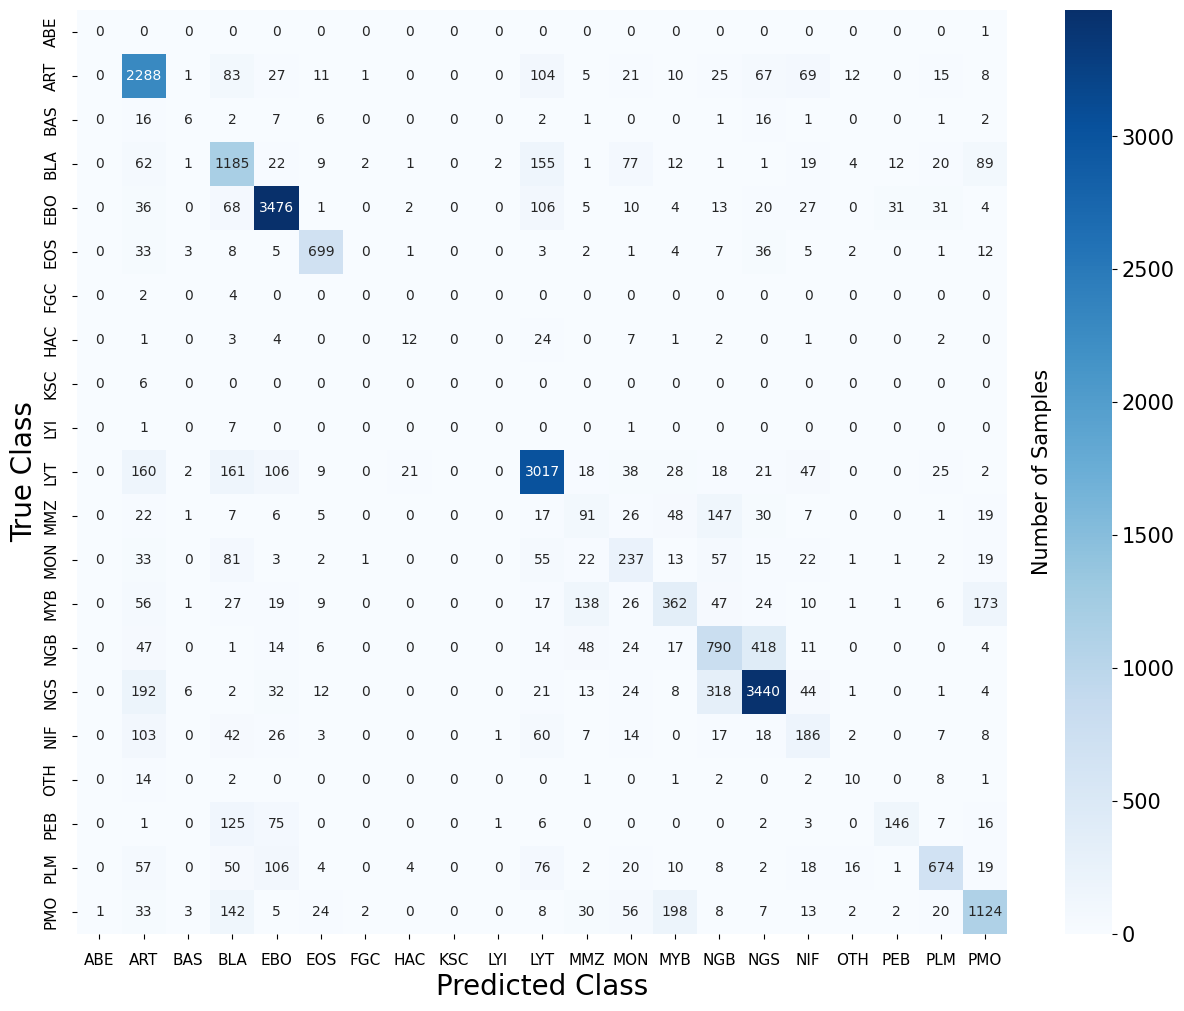

In [59]:
conf_matrix = plot_confusion_matrix(y_true, y_pred, class_names)

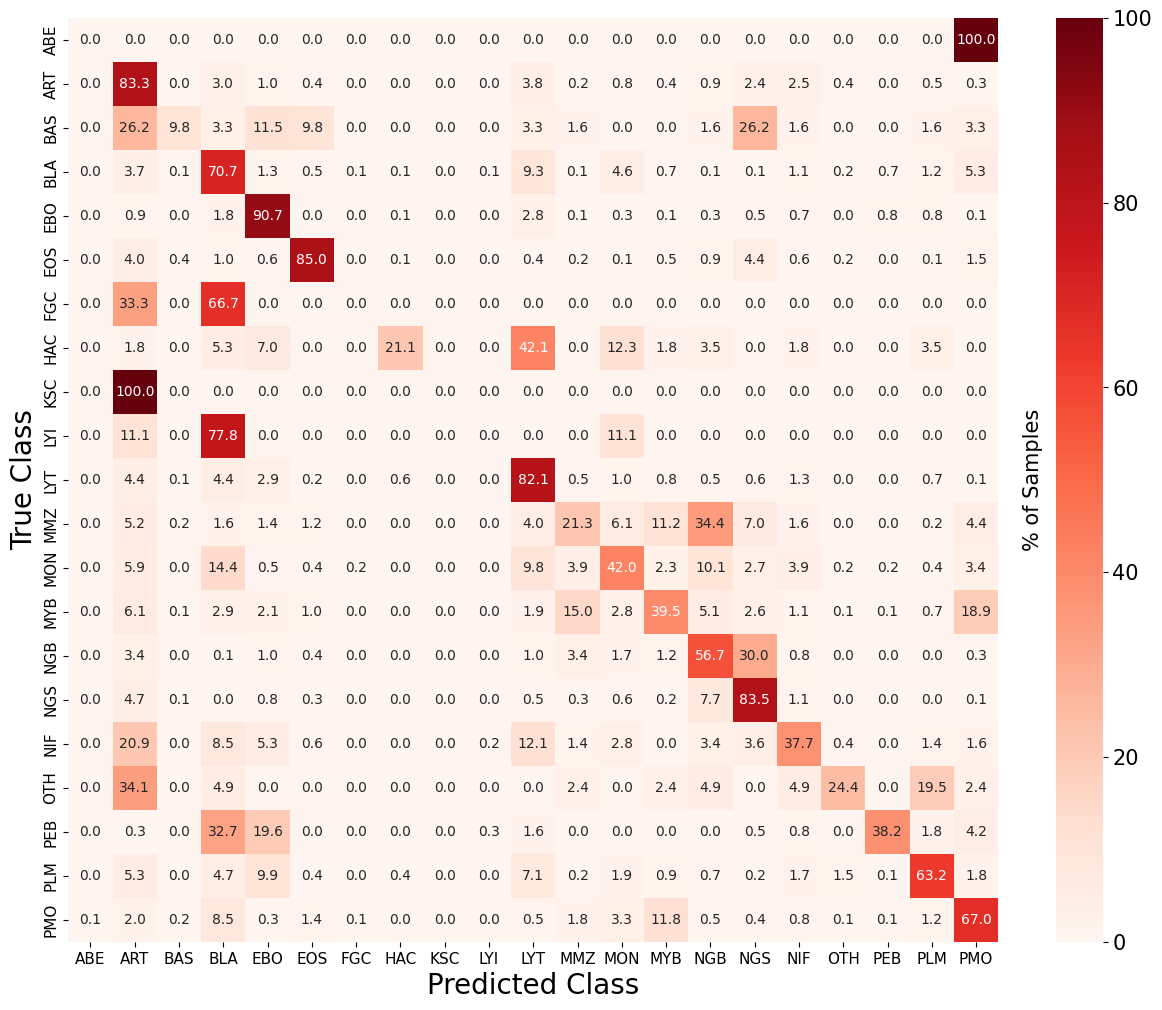

In [60]:
normalised_conf_matrix = plot_normalised_confusion_matrix(conf_matrix)

In [61]:
with open(os.path.join(folder, inner_folder, 'classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder, 'confusion_data'), 'wb') as f:
    pickle.dump(conf_matrix, f)
    
with open(os.path.join(folder, inner_folder, 'normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_conf_matrix, f)

# 2. Optimised Model Metrics

In [78]:
folder = 'pickle'
inner_folder = 'optimised'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)
    
with open(os.path.join(folder, inner_folder, 'history_pickle'), 'rb') as f:
    loaded_history = pickle.load(f)

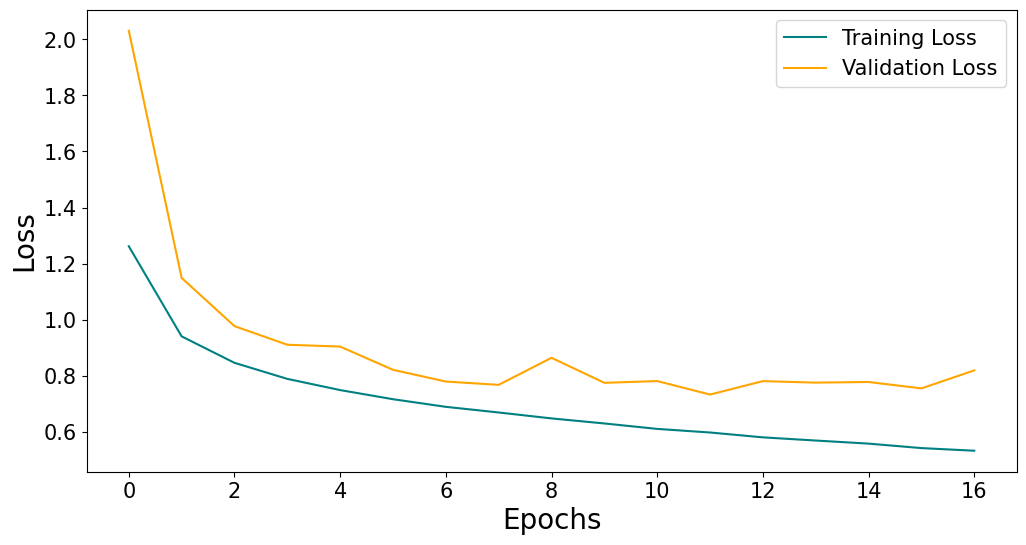

In [63]:
plot_loss(loaded_history)

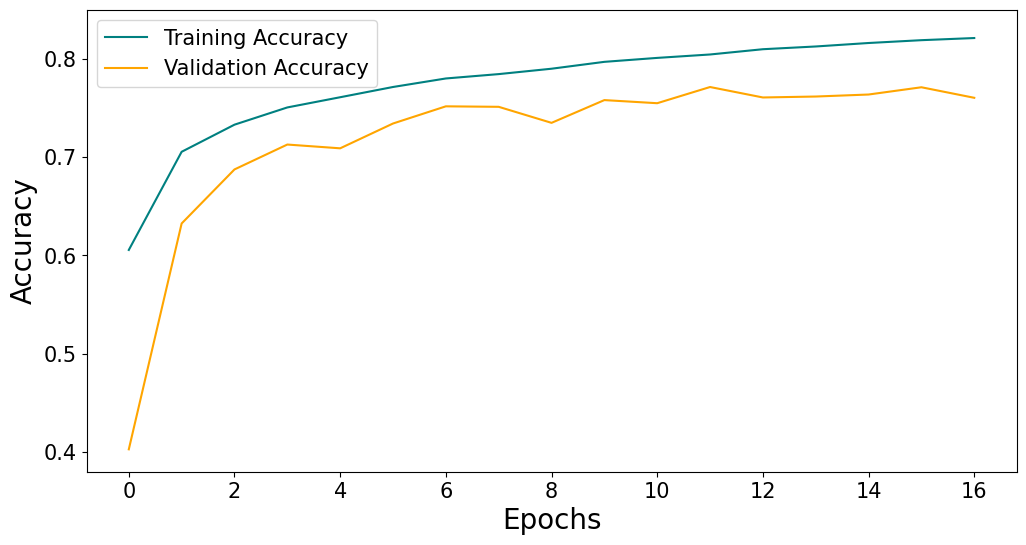

In [82]:
plot_accuracy(0.38, 0.85, loaded_history)

In [65]:
reset_metrics()
y_true, y_pred = predict(model)

In [66]:
class_report = create_classification_report(y_true, y_pred)

Accuracy:0.7603971362113953
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.72      0.86      0.78      2747
         BAS       0.00      0.00      0.00        61
         BLA       0.68      0.61      0.65      1675
         EBO       0.89      0.90      0.90      3834
         EOS       0.95      0.74      0.84       822
         FGC       0.00      0.00      0.00         6
         HAC       0.50      0.07      0.12        57
         KSC       0.00      0.00      0.00         6
         LYI       0.00      0.00      0.00         9
         LYT       0.82      0.87      0.84      3673
         MMZ       0.30      0.15      0.20       427
         MON       0.54      0.47      0.50       564
         MYB       0.62      0.32      0.42       917
         NGB       0.52      0.70      0.60      1394
         NGS       0.87      0.83      0.85      4118
         NIF       0.60      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


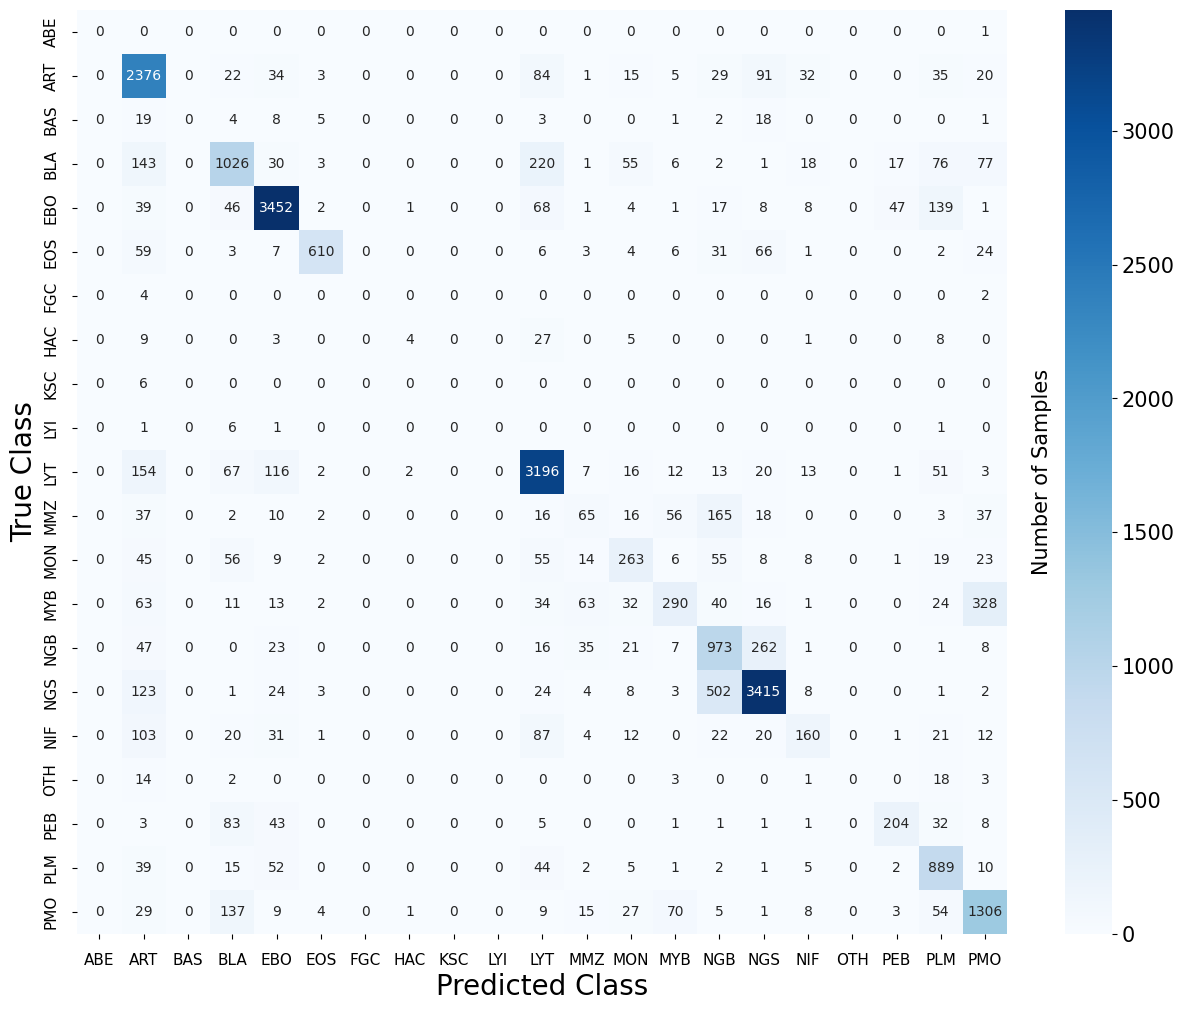

In [67]:
conf_matrix = plot_confusion_matrix(y_true, y_pred, class_names)

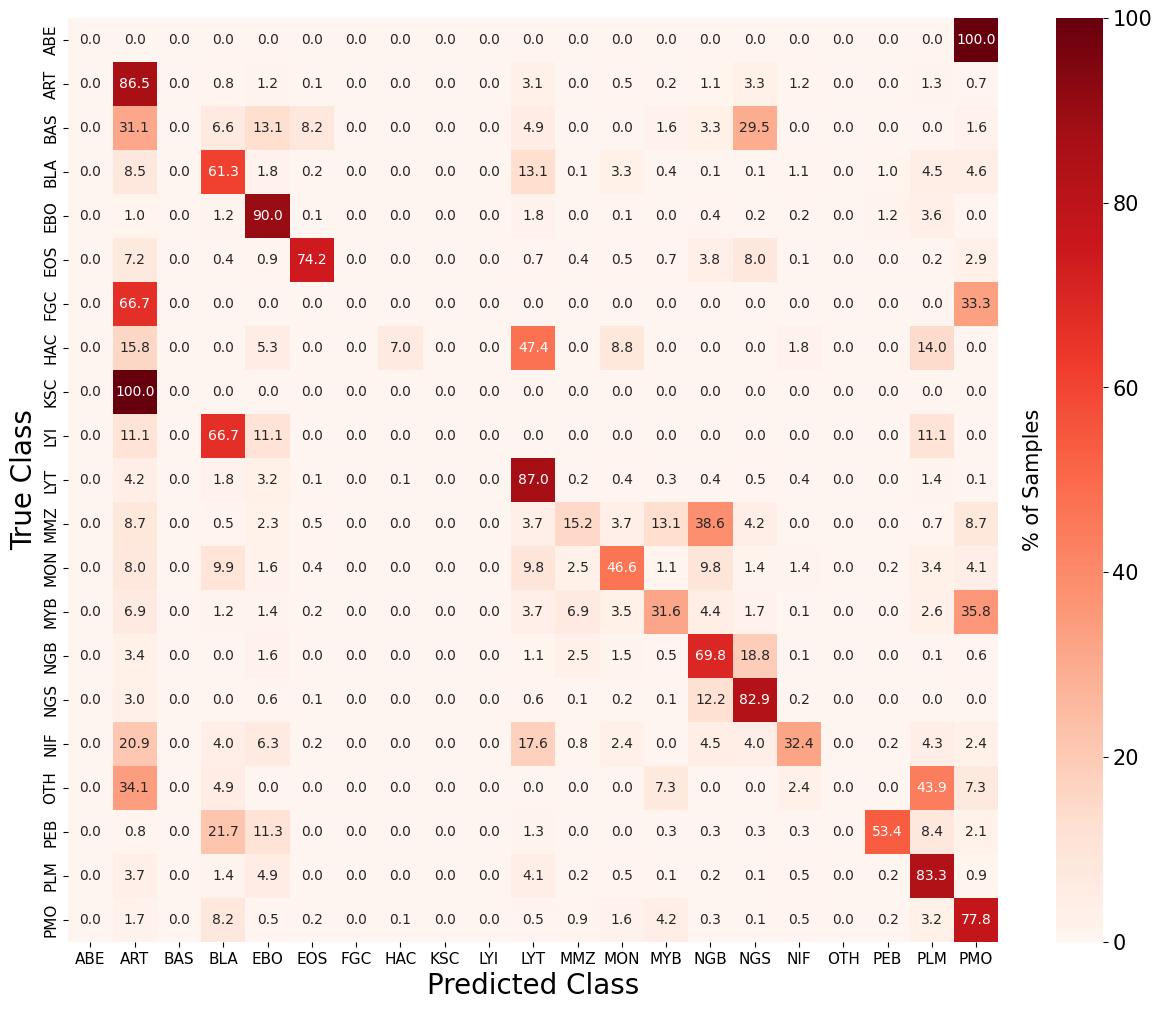

In [68]:
normalised_conf_matrix = plot_normalised_confusion_matrix(conf_matrix)

In [69]:
with open(os.path.join(folder, inner_folder, 'classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder,  'confusion_data'), 'wb') as f:
    pickle.dump(conf_matrix, f)
    
with open(os.path.join(folder, inner_folder, 'normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_conf_matrix, f)

# 3. Optimised Model (With Data Augmentation) Metrics

In [70]:
folder = 'pickle'
inner_folder = 'augmented'

with open(os.path.join(folder, inner_folder, 'model_pickle'), 'rb') as f:
    model = pickle.load(f)
    
with open(os.path.join(folder, inner_folder, 'history_pickle'), 'rb') as f:
    loaded_history = pickle.load(f)

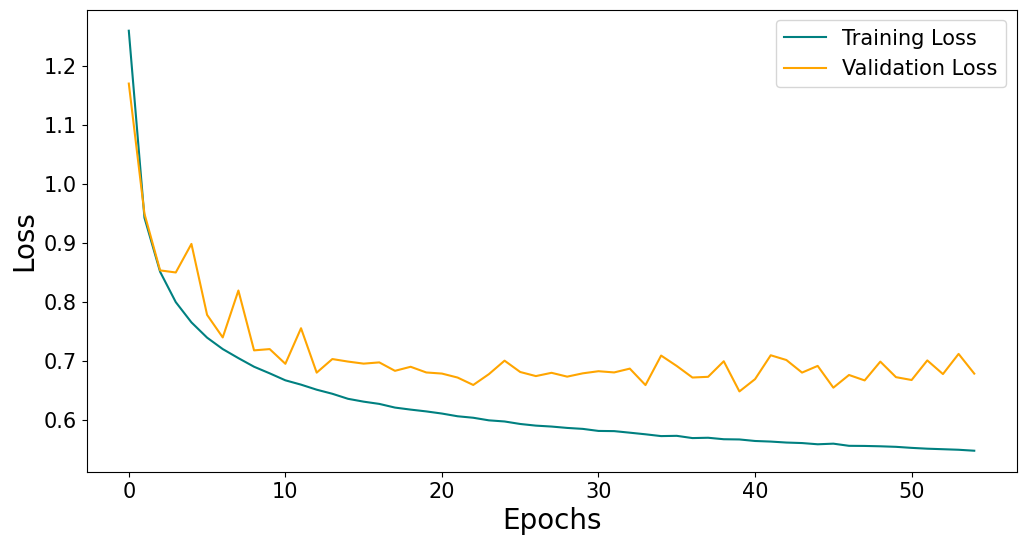

In [71]:
plot_loss(loaded_history)

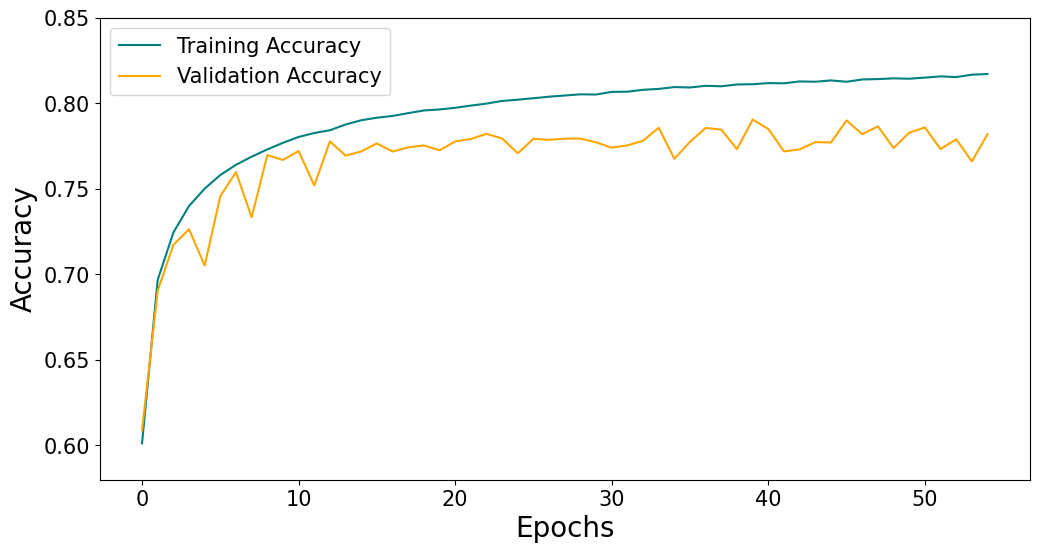

In [72]:
plot_accuracy(0.58, 0.85, loaded_history)

In [73]:
reset_metrics()
y_true, y_pred = predict(model)

In [74]:
class_report = create_classification_report(y_true, y_pred)

Accuracy:0.7818796038627625
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.86      0.78      0.82      2747
         BAS       0.20      0.61      0.30        61
         BLA       0.75      0.70      0.72      1675
         EBO       0.88      0.92      0.90      3834
         EOS       0.88      0.93      0.90       822
         FGC       0.14      0.50      0.21         6
         HAC       0.29      0.58      0.39        57
         KSC       0.13      0.33      0.19         6
         LYI       0.05      0.11      0.07         9
         LYT       0.87      0.84      0.86      3673
         MMZ       0.34      0.51      0.41       427
         MON       0.49      0.67      0.57       564
         MYB       0.59      0.56      0.58       917
         NGB       0.58      0.66      0.61      1394
         NGS       0.90      0.81      0.85      4118
         NIF       0.53      

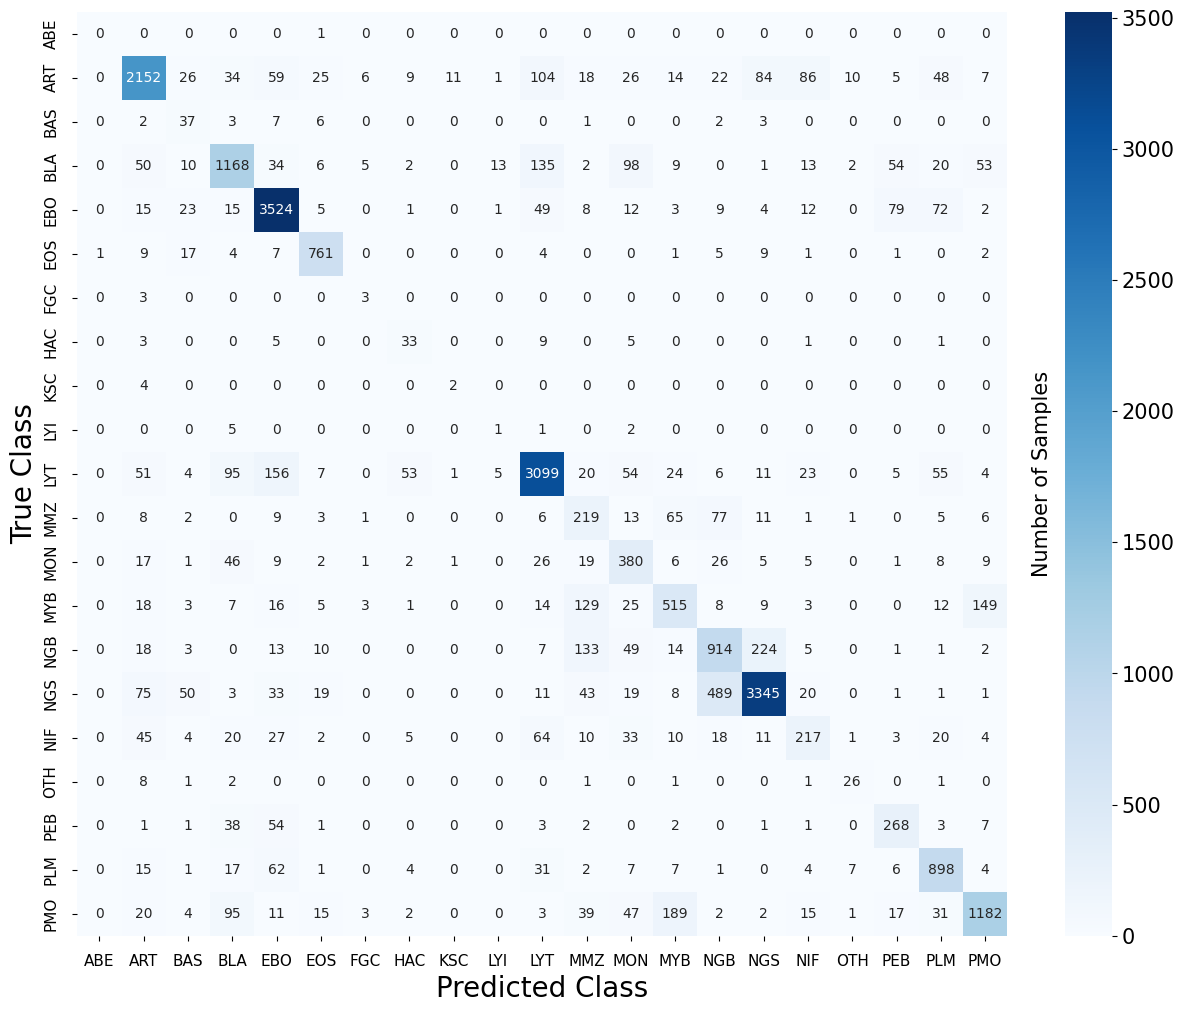

In [75]:
conf_matrix = plot_confusion_matrix(y_true, y_pred, class_names)

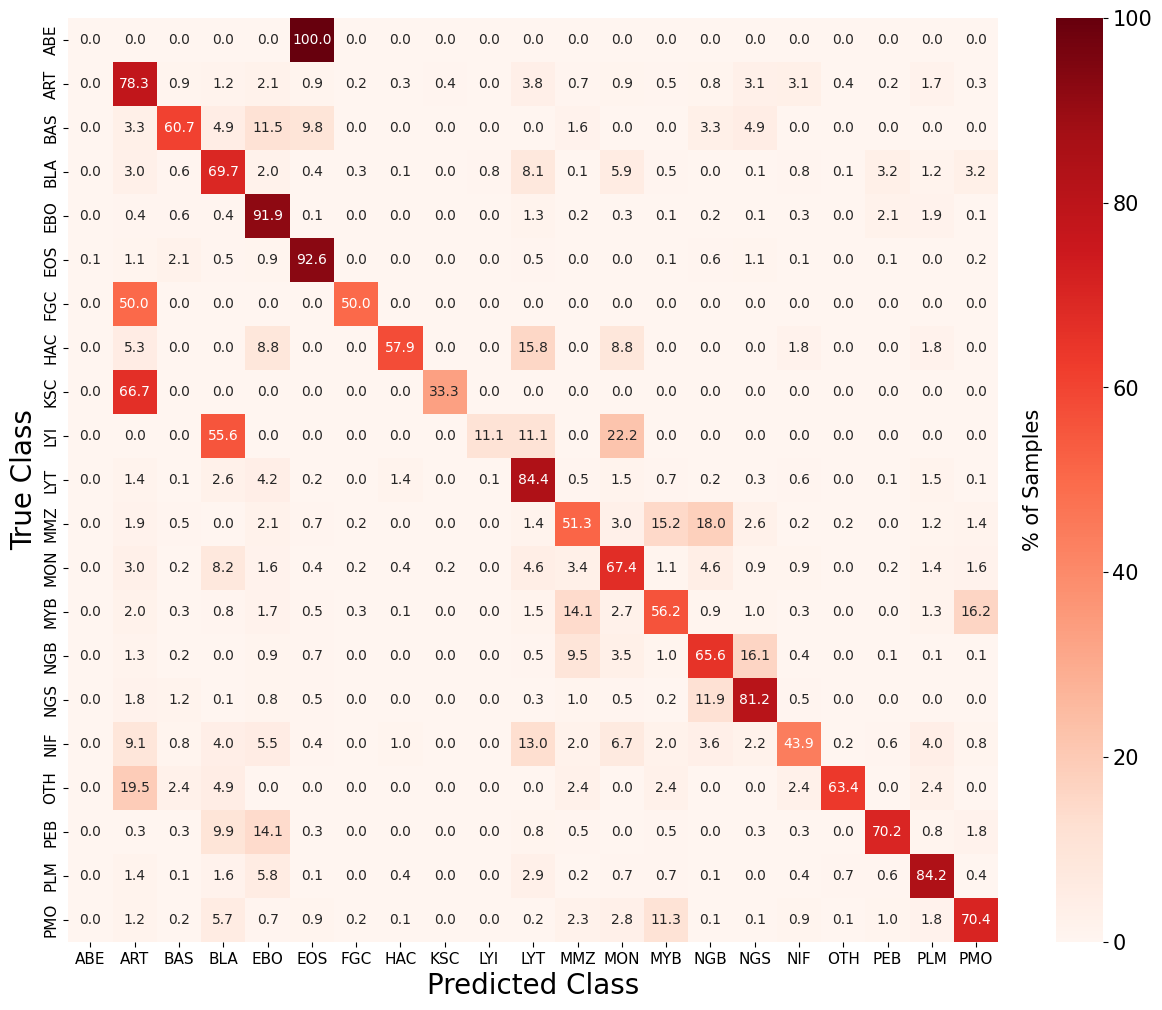

In [76]:
normalised_conf_matrix = plot_normalised_confusion_matrix(conf_matrix)

In [77]:
with open(os.path.join(folder, inner_folder, 'classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_folder,  'confusion_data'), 'wb') as f:
    pickle.dump(conf_matrix, f)
    
with open(os.path.join(folder, inner_folder, 'normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_conf_matrix, f)